In [13]:
import os
if not os.path.exists("portfolio-optimizer-notebooks"):
    !git clone https://github.com/drewtilley/portfolio-optimizer-notebooks.git

# Install dependencies
verbose=False
if verbose:
    !pip install -r portfolio-optimizer-notebooks/requirements.txt
else:
    !pip install -r portfolio-optimizer-notebooks/requirements.txt > /dev/null 2>&1

# Add the utils path to Python's module search path
import sys
sys.path.append("portfolio-optimizer-notebooks/utils")

Cloning into 'portfolio-optimizer-notebooks'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33 (delta 11), reused 25 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 472.66 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [5]:
# Module Imports
import PortfolioOptimizer
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
# Display Settings
if "google.colab" in sys.modules:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
else:
    pd.set_option('display.notebook_repr_html', True)

%matplotlib inline

---
### Portfolio Risk Management with RiskModels

This notebook demonstrates the use of RiskModels, a portfolio risk tool developed by Blue Water Macro.

We demonstrate how to:

- Construct portfolios using curated return and risk datasets
- Apply multiple risk model frameworks—including historical and multi-factor approaches
- Run flexible optimizations (e.g., Sharpe ratio maximization, minimum variance, and custom constraints)

The included PortfolioOptimizer module is built on top of the powerful [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/) framework. It simplifies interaction with RiskModels data and streamlines common portfolio construction workflows—offering users a clean, high-level interface without requiring deep familiarity with Riskfolio’s internal configuration.

### Getting Started

This notebook demonstrates how to use the **RiskModels** platform for portfolio construction and risk management. The examples below use a curated public dataset derived from Blue Water Macro's internal analytics pipeline.

The dataset includes daily equity data for a selected universe of U.S. stocks, enriched with return decompositions, factor exposures, and risk contributions across both **market** and **sector** dimensions.

#### Available Data Fields

Each security is indexed by `ticker` and `date`. The key variables include:

* **Returns**

  * `return`: Total daily return
  * `residual_return`: Return unexplained by market or sector factors
  * `market_factor_return`, `sector_factor_return`: Returns from market and sector ETFs

* **Risk Attribution**

  * `gross_return_variance`: Total variance of returns
  * `market_risk_pct`, `sector_risk_pct`, `residual_risk_pct`: Proportional contribution to risk
  * `market_contr_variance`, `sector_contr_variance`, `residual_variance`: Absolute risk components

* **Factor Exposures (Betas)**

  * `market_beta`, `sector_beta`, `sector_factor_beta`: Sensitivity to market and sector factors
  * `etf_mkt_beta`: Beta relative to a tradable ETF proxy for the market

* **Hedging Signals**

  * `market_hedge_wt`, `sector_hedge_wt`: Suggested hedge weights to neutralize market/sector exposure

* **Classification & Metadata**

  * `bw_sector_code`, `bw_sector_name`: Sector identifiers
  * `sector_etf`: ETF representing the sector
  * `mktcap`: Market capitalization
  * `cross_term_risk_pct`: Interaction term for higher-order risk effects

---

### Data Access and Structure

Blue Water Macro (BWM) distributes its quantitative datasets using the **Zarr** format, backed by **Xarray** — enabling efficient, scalable access to high-dimensional labeled data. For this public demonstration, we've extracted a representative subset and made it available as a **CSV file**.

We'll begin by downloading and inspecting the CSV version of the dataset.

In [4]:
# URL: the Testing dataset has a year of history for 10 large cap stocks
url = 'https://storage.googleapis.com/rm_public_csv/Testing.csv'

# Retrieve the csv and read as a dataframe
rm_demo_df = pd.read_csv(url,
                         index_col=['date', 'ticker'],
                         parse_dates=['date'],
                         date_format='%Y-%m-%d'
                        )

In [12]:
# Inspect the dataframe
display(pd.concat([rm_demo_df.head(10), rm_demo_df.tail(10)]))

bw_sector_code          bw_sector_name    close  \
date       ticker                                                    
2024-06-20 NFLX              45.0  Information_Technology   679.03   
           UNH               35.0             Health_Care   484.52   
           NVDA              45.0  Information_Technology   130.78   
           JNJ               35.0             Health_Care   147.78   
           AMZN              25.0  Consumer_Discretionary   186.10   
           JPM               40.0              Financials   198.67   
           XOM               10.0                  Energy   111.74   
           META              45.0  Information_Technology   501.70   
           PG                30.0        Consumer_Staples   167.67   
           GOOG              45.0  Information_Technology   177.71   
2025-06-18 NFLX              45.0  Information_Technology  1222.29   
           UNH               35.0             Health_Care   307.20   
           NVDA              45.0  Information_Technology   145.48   
           JNJ               35.0             Health_Care   150.73   
           AMZN              25.0  Consumer_Discretionary   212.52   
           JPM               40.0              Financials   273.96   
           XOM               10.0                  Energy   113.19   
           META              45.0  Information_Technology   695.77   
           PG                30.0        Consumer_Staples   158.02   
           GOOG              45.0  Information_Technology   173.98   

                   cross_term_risk_pct  etf_mkt_beta  gross_return_variance  \
date       ticker                                                             
2024-06-20 NFLX               0.004155      1.309033               4.782536   
           UNH                0.003977      0.566217               1.786410   
           NVDA               0.015255      1.309033               7.752535   
           JNJ                0.005828      0.566217               1.032109   
           AMZN               0.002411      1.175337               3.029408   
           JPM                0.031164      0.781520               1.176447   
           XOM                0.013093      0.456429               1.678766   
           META               0.003091      1.309033               5.087494   
           PG                 0.006325      0.373177               0.738789   
           GOOG               0.003534      1.309033               3.043744   
2025-06-18 NFLX               0.002076      1.282467               4.134276   
           UNH                0.000259      0.499822               7.785646   
           NVDA               0.008120      1.282467              13.415474   
           JNJ                0.001055      0.499822               1.418358   
           AMZN               0.006265      1.182237               4.748329   
           JPM                0.015320      0.814214               3.133251   
           XOM                0.013064      0.767930               2.252627   
           META               0.003064      1.282467               5.438071   
           PG                 0.005043      0.354155               1.461459   
           GOOG               0.003018      1.282467               3.893928   

                   market_beta  market_contr_variance  market_factor_return  \
date       ticker                                                             
2024-06-20 NFLX       1.214309               0.888269               -0.2717   
           UNH        0.260285               0.067958               -0.2717   
           NVDA       2.313531               1.978843               -0.2717   
           JNJ        0.210629               0.034038               -0.2717   
           AMZN       1.392119               1.222697               -0.2717   
           JPM        0.649675               0.289884               -0.2717   
           XOM        0.360800               0.113143               -0.2717   
           META       1.6428

In [15]:
# Store the tickers in this dataset for reference 
tickers = rm_demo_df.index.get_level_values('ticker').unique().to_list()
print(tickers)

['NFLX', 'UNH', 'NVDA', 'JNJ', 'AMZN', 'JPM', 'XOM', 'META', 'PG', 'GOOG']


In [16]:
# Check the dataframe shape: (num_tickers x num_trading_dates, num_data_fields
rm_demo_df.shape

(2500, 23)

#### Converting to an Xarray Dataset

RiskModels data is natively structured as an **`xarray.Dataset`** to support efficient access and manipulation of multi-dimensional arrays — such as returns, factor exposures, and risk decompositions across tickers and time.

The current `PortfolioOptimizer` module expects inputs to be of `xarray.Dataset` type. The long-term design goal is to support workflows that integrate seamlessly with `xarray`. In this notebook, we demonstrate how to convert the sample data to an `xarray.Dataset` for advanced slicing and previewing. 

The optimizer analyzes all tickers and dates in the input xarray.Dataset as a single investment period. It assumes that you’ve already selected the specific assets and timeframe you wish to analyze.

Fortunately, Xarray’s intuitive syntax makes it easy to subset the dataset by time range and ticker before optimization.

In [17]:
# Convert to xarray.Dataset
rm_demo_ds = xr.Dataset.from_dataframe(rm_demo_df)

In [20]:
# Dataset variables
print(rm_demo_ds.data_vars)

Data variables:
    bw_sector_code         (date, ticker) float64 20kB 25.0 45.0 ... 35.0 10.0
    bw_sector_name         (date, ticker) object 20kB 'Consumer_Discretionary...
    close                  (date, ticker) float64 20kB 186.1 177.7 ... 113.2
    cross_term_risk_pct    (date, ticker) float64 20kB 0.002411 ... 0.01306
    etf_mkt_beta           (date, ticker) float64 20kB 1.175 1.309 ... 0.7679
    gross_return_variance  (date, ticker) float64 20kB 3.029 3.044 ... 2.253
    market_beta            (date, ticker) float64 20kB 1.392 1.055 ... 0.4949
    market_contr_variance  (date, ticker) float64 20kB 1.223 0.7997 ... 0.1353
    market_factor_return   (date, ticker) float64 20kB -0.2717 ... -0.0151
    market_hedge_wt        (date, ticker) float64 20kB -1.162 -0.5013 ... 0.2706
    market_risk_pct        (date, ticker) float64 20kB 0.3854 0.2589 ... 0.06132
    mktcap                 (date, ticker) float64 20kB 1.836e+12 ... 4.552e+11
    residual_return        (date, ticker) f

In [21]:
# Dataset dimensions
print(rm_demo_ds.dims)

FrozenMappingWarningOnValuesAccess({'date': 250, 'ticker': 10})


In [22]:
# Slice by date
rm_demo_ds.sel(date=slice("2025-01-01", "2025-03-31"))

<xarray.Dataset> Size: 111kB
Dimensions:                (date: 60, ticker: 10)
Coordinates:
  * date                   (date) datetime64[ns] 480B 2025-01-02 ... 2025-03-31
  * ticker                 (ticker) object 80B 'AMZN' 'GOOG' ... 'UNH' 'XOM'
Data variables: (12/23)
    bw_sector_code         (date, ticker) float64 5kB 25.0 45.0 ... 35.0 10.0
    bw_sector_name         (date, ticker) object 5kB 'Consumer_Discretionary'...
    close                  (date, ticker) float64 5kB 220.2 190.6 ... 118.9
    cross_term_risk_pct    (date, ticker) float64 5kB 0.008085 ... 0.01106
    etf_mkt_beta           (date, ticker) float64 5kB 1.351 1.505 ... 0.6003
    gross_return_variance  (date, ticker) float64 5kB 3.11 3.032 ... 3.394 1.61
    ...                     ...
    sector_contr_variance  (date, ticker) float64 5kB 0.1007 0.0474 ... 1.352
    sector_etf             (date, ticker) object 5kB 'XLY' 'XLK' ... 'XLV' 'XLE'
    sector_factor_beta     (date, ticker) float64 5kB 0.5664 -0.1803 ... 0.9393
    sector_factor_return   (date, ticker) float64 5kB -0.9831 0.1333 ... 0.7005
    sector_hedge_wt        (date, ticker) float64 5kB -0.5664 0.1803 ... -0.9393
    sector_risk_pct        (date, ticker) float64 5kB 0.03408 0.01616 ... 0.7526

In [23]:
# Slice by ticker
rm_demo_ds.sel(ticker=["AMZN", "GOOG"])

<xarray.Dataset> Size: 94kB
Dimensions:                (date: 250, ticker: 2)
Coordinates:
  * date                   (date) datetime64[ns] 2kB 2024-06-20 ... 2025-06-18
  * ticker                 (ticker) object 16B 'AMZN' 'GOOG'
Data variables: (12/23)
    bw_sector_code         (date, ticker) float64 4kB 25.0 45.0 ... 25.0 45.0
    bw_sector_name         (date, ticker) object 4kB 'Consumer_Discretionary'...
    close                  (date, ticker) float64 4kB 186.1 177.7 ... 174.0
    cross_term_risk_pct    (date, ticker) float64 4kB 0.002411 ... 0.003018
    etf_mkt_beta           (date, ticker) float64 4kB 1.175 1.309 ... 1.282
    gross_return_variance  (date, ticker) float64 4kB 3.029 3.044 ... 3.894
    ...                     ...
    sector_contr_variance  (date, ticker) float64 4kB 0.3788 0.07317 ... 0.02919
    sector_etf             (date, ticker) object 4kB 'XLY' 'XLK' ... 'XLY' 'XLK'
    sector_factor_beta     (date, ticker) float64 4kB 0.1958 0.4228 ... 0.6007
    sector_factor_return   (date, ticker) float64 4kB 0.4465 -0.7678 ... 0.1396
    sector_hedge_wt        (date, ticker) float64 4kB -0.1958 ... -0.6007
    sector_risk_pct        (date, ticker) float64 4kB 0.1194 ... 0.005963

In [26]:
# Subset by date range and ticker
rm_demo_ds.sel(date=slice("2025-01-01","2025-03-31"), ticker=["GOOG","NVDA"])

<xarray.Dataset> Size: 23kB
Dimensions:                (date: 60, ticker: 2)
Coordinates:
  * date                   (date) datetime64[ns] 480B 2025-01-02 ... 2025-03-31
  * ticker                 (ticker) object 16B 'GOOG' 'NVDA'
Data variables: (12/23)
    bw_sector_code         (date, ticker) float64 960B 45.0 45.0 ... 45.0 45.0
    bw_sector_name         (date, ticker) object 960B 'Information_Technology...
    close                  (date, ticker) float64 960B 190.6 138.3 ... 108.4
    cross_term_risk_pct    (date, ticker) float64 960B -0.001806 ... 0.01555
    etf_mkt_beta           (date, ticker) float64 960B 1.505 1.505 ... 1.518
    gross_return_variance  (date, ticker) float64 960B 3.032 10.88 ... 12.51
    ...                     ...
    sector_contr_variance  (date, ticker) float64 960B 0.0474 1.911 ... 2.452
    sector_etf             (date, ticker) object 960B 'XLK' 'XLK' ... 'XLK'
    sector_factor_beta     (date, ticker) float64 960B -0.1803 2.505 ... 2.699
    sector_factor_return   (date, ticker) float64 960B 0.1333 0.1333 ... -0.9706
    sector_hedge_wt        (date, ticker) float64 960B 0.1803 -2.505 ... -2.699
    sector_risk_pct        (date, ticker) float64 960B 0.01616 0.1894 ... 0.215

---
### Portfolio Construction: Classic Optimization

The `ClassicOptimizer` class provides a simple interface for optimizing portfolios using **historical return data**. It wraps functionality from `Riskfolio-Lib:Portfolio` object and checks the setting configuration.

The following example demonstrates how to maximize the Sharpe Ratio on `residual_return` in the dataset to compute optimized portfolio weights. This highlights the stock-specific performance and simulates a market- and sector-neutral portfolio. It’s a simple way to explore alpha generation using factor-aware data. In this configuration the expected returns vector (`μ`) and covariance matrix (`Σ`) are estimated from historical sample estimates.

> ℹ️ **Note**: Riskfolio supports many different models and configurations the `ClassicOptimizer.port` attribute can be further configured.

```python
classic_mvo = ClassicOptimizer(
    daily_ds=rm_demo_ds,
    optimizer_config={
        "model": "Classic",  # classic mean-variance
        "rm": "MV",          # risk measure: variance
        "rf": 0,             # risk-free rate
        "l": 0,              # risk aversion (has no meaning in this configuration)
        "hist": True,        # use historical estimates for mu and sigma
        "obj": "Sharpe"      # Valid objectives ["Sharpe", "MinRisk", "MaxRet", "Utility"]
    }
)
```

In [30]:
# Create the ClassicOptimizer instance using the configuration defaults
classic_mvo = PortfolioOptimizer.ClassicOptimizer(rm_demo_ds)

In [36]:
# Inspect the configuration
classic_mvo.optimizer_config

{'model': 'Classic', 'rm': 'MV', 'rf': 0, 'l': 0, 'hist': True}

In [31]:
# Optimize on residual returns
classic_mvo.optimize(returns_col='residual_return', LongOnly=False)

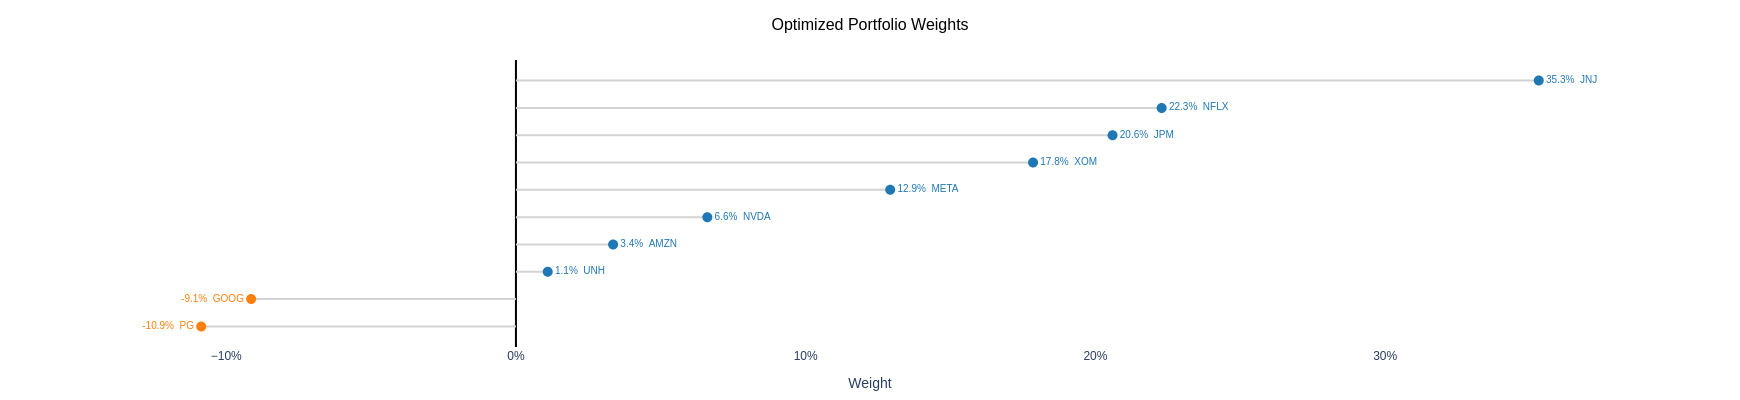

In [32]:
# Visualize optimalized weights 
classic_mvo.plot_weights_plotly()

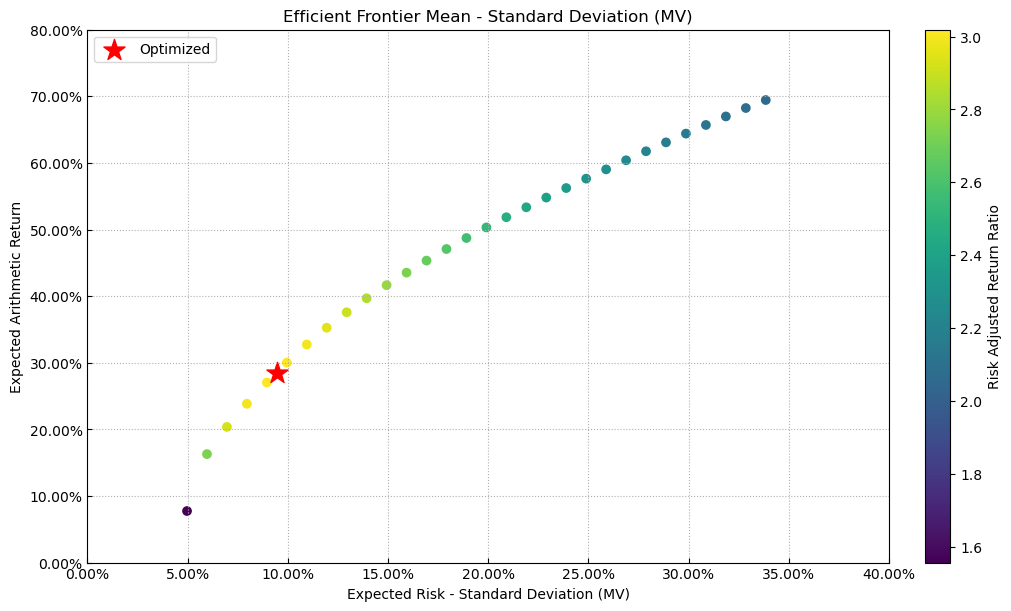

In [33]:
# Visualize the efficient frontier 
classic_mvo.plot_frontier()

In [34]:
# Portfolio is not leveraged
classic_mvo.w.sum()

weights    1.0
dtype: float64

In [35]:
# Optionally: you can leverage the portfolio by settting the budget greater than 1.0
classic_mvo.port.budget

1.0

---

### Portfolio Construction: Factor Model Optimization

The `FactorModelOptimizer` class enables portfolio optimization using a **linear factor model**, where both the expected returns (**μ**) and the covariance matrix (**Σ**) are explicitly constructed using **RiskModels factor data**. This class is ideal for users who want to take full advantage of the structured risk decomposition offered by Blue Water Macro’s proprietary equity models.

Unlike the `ClassicOptimizer`, which relies on historical asset return samples, this class constructs **Σ** using the factor model equation:

$$
\Sigma = BFB^\top + D
$$

This allows for more transparent and robust control over systematic and idiosyncratic risk assumptions.

> ⚠️ **Note**: Although Riskfolio-Lib includes its own internal support for factor models, `FactorModelOptimizer` bypasses that functionality. Instead, it directly constructs the inputs (`μ` and `Σ`) from pre-calculated factor exposures, returns, and residual variances in the input dataset. This is more flexible and accurate when using institutional-grade risk model inputs.

#### Constructing the Covariance Matrix and Expected Returns

To compute the expected returns (**μ**) and asset return covariance matrix (**Σ**) using the factor model, use the `calculate_fm_cov()` function.

This constructs the factor-based covariance matrix performing the following steps:

1. Selects the trailing factor return window of length `n_window`
2. Builds the factor exposure matrix **B** using the end-of-window data
3. Computes the factor covariance matrix **F**
4. Assembles the diagonal residual variance matrix **D**
5. Computes:

   * Expected returns:     **μ = B · f**
   * Covariance matrix:    **Σ = B · F · Bᵗ + D**

##### 📌 Selecting the trailing window for estimating the expected factor returns.

You can control both the **length of the lookback window** and the **ending date** of that window to align with your analysis date. Here are some common usage patterns:

**Default behavior (use entire history):**

```python
factor_mvo.calculate_fm_cov()
```

Uses **all available dates** up to the last one in the dataset. This is useful for exploratory analysis or small datasets.

**Fixed trailing window (e.g., 60 trading days):**

```python
factor_mvo.calculate_fm_cov(n_window=60)
```

Computes μ and Σ using the last 60 trading days in the dataset. This reflects a short-term investment horizon and more reactive covariance estimates.

**Specify a custom end date (e.g., quarterly rebalance):**

```python
factor_mvo.calculate_fm_cov(n_window=90, end_window="2025-03-31")
```

Computes μ and Σ using the 90 trading days leading up to **March 31, 2025**. This is useful for simulations, backtesting, or aligning optimization with a rebalancing schedule.

If the date is not found in the dataset, a helpful error will be raised showing the available date range.

These examples show how `FactorModelOptimizer` gives you **full control over the investment horizon** and **alignment of expected returns** and **covariances** with your specific use case.

Let me know if you’d like a visualization of how the trailing window is selected over time, or if you want to extend this for monthly rebalancing workflows.


Once these components are calculated, optimization can proceed using Riskfolio's standard API but with fully custom inputs:

```python
factor_mvo.optimize(LongOnly=True)
```

This structure gives you the control and clarity of a custom risk model implementation, with the convenience of Riskfolio's optimization engine.

---

In [38]:
# Create the FactorModelOptimizer instance using the configuration defaults
factor_model = PortfolioOptimizer.FactorModelOptimizer(rm_demo_ds)

In [42]:
# Inspect the configuration
factor_model.optimizer_config

{'model': 'Classic', 'rm': 'MV', 'rf': 0, 'l': 0, 'hist': False}

In [43]:
# Construct the covariance matrix sigma using the entire history
factor_model.calculate_fm_cov()

In [44]:
# Inspect the exposure matrix B
factor_model.B

,market_beta,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
ticker,,,,,,,
AMZN,1.279137,0.922753,0.000000,0.000000,0.000000,0.000000,0.000000
GOOG,1.004298,0.000000,0.000000,0.000000,0.000000,0.000000,0.600650
JNJ,0.060335,0.000000,0.000000,0.000000,0.000000,1.011271,0.000000
JPM,0.880639,0.000000,0.000000,0.000000,1.070058,0.000000,0.000000
META,1.407166,0.000000,0.000000,0.000000,0.000000,0.000000,0.530078
NFLX,0.851564,0.000000,0.000000,0.000000,0.000000,0.000000,0.514257
NVDA,1.735625,0.000000,0.000000,0.000000,0.000000,0.000000,2.960326
PG,0.229182,0.000000,1.117728,0.000000,0.000000,0.000000,0.000000
UNH,0.074634,0.000000,0.000000,0.000000,0.000000,0.946002,0.000000


In [45]:
# Inspect the expected factor returns
factor_model.f

,f
Market,0.000475
Consumer_Discretionary,0.000245
Consumer_Staples,0.000098
Energy,-0.000025
Financials,0.000589
Health_Care,-0.000476
Information_Technology,-0.000282


In [17]:
# Inspect the expected factor covariance matrix
factor_model.F

,Market,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
Market,0.000167,-2.372305e-05,-0.000003,0.000040,9.363876e-06,0.000014,-0.000015
Consumer_Discretionary,-0.000024,5.605051e-05,-0.000003,-0.000020,-2.287985e-07,-0.000013,-0.000003
Consumer_Staples,-0.000003,-2.947498e-06,0.000061,0.000003,1.565338e-05,0.000035,-0.000031
Energy,0.000040,-2.028537e-05,0.000003,0.000162,2.948123e-05,0.000010,-0.000029
Financials,0.000009,-2.287985e-07,0.000016,0.000029,5.560873e-05,0.000015,-0.000031
Health_Care,0.000014,-1.253157e-05,0.000035,0.000010,1.471170e-05,0.000067,-0.000030
Information_Technology,-0.000015,-3.170185e-06,-0.000031,-0.000029,-3.148435e-05,-0.000030,0.000047


In [46]:
# Inspect the residual variance matrix
factor_model.D

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015399,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
GOOG,0.000000,0.023083,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
JNJ,0.000000,0.000000,0.008211,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
JPM,0.000000,0.000000,0.000000,0.007085,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
META,0.000000,0.000000,0.000000,0.000000,0.024252,0.00000,0.000000,0.000000,0.000000,0.000000
NFLX,0.000000,0.000000,0.000000,0.000000,0.000000,0.02802,0.000000,0.000000,0.000000,0.000000
NVDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.024818,0.000000,0.000000,0.000000
PG,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.005799,0.000000,0.000000
UNH,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.066752,0.000000


In [47]:
# Inspect the full covariance matrix
factor_model.sigma

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015664,0.000179,0.000017,0.000181,0.000257,0.000151,0.000266,0.000037,0.000020,0.000127
GOOG,0.000179,0.023250,0.000005,0.000129,0.000230,0.000142,0.000314,0.000013,0.000008,0.000101
JNJ,0.000017,0.000005,0.008282,0.000038,0.000017,0.000004,-0.000051,0.000045,0.000067,0.000024
JPM,0.000181,0.000129,0.000038,0.007296,0.000196,0.000109,0.000133,0.000052,0.000038,0.000144
META,0.000257,0.000230,0.000017,0.000196,0.024573,0.000195,0.000404,0.000030,0.000020,0.000153
NFLX,0.000151,0.000142,0.000004,0.000109,0.000195,0.028140,0.000267,0.000011,0.000006,0.000085
NVDA,0.000266,0.000314,-0.000051,0.000133,0.000404,0.000267,0.025579,-0.000050,-0.000044,0.000103
PG,0.000037,0.000013,0.000045,0.000052,0.000030,0.000011,-0.000050,0.005882,0.000043,0.000030
UNH,0.000020,0.000008,0.000067,0.000038,0.000020,0.000006,-0.000044,0.000043,0.066815,0.000025


In [48]:
factor_model.optimize(LongOnly=False)

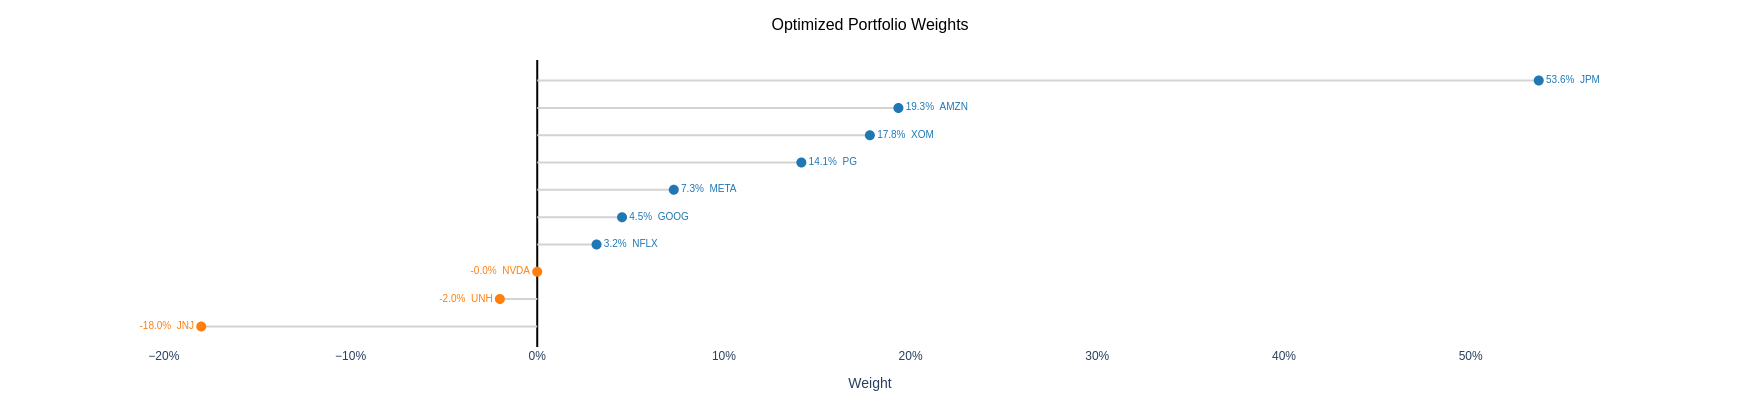

In [50]:
# Visualize optimalized weights 
factor_model.plot_weights_plotly()

In [24]:
factor_model.mu

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
0,0.000833,0.000307,-0.000452,0.001049,0.000518,0.000259,-0.000012,0.000219,-0.000415,0.00021


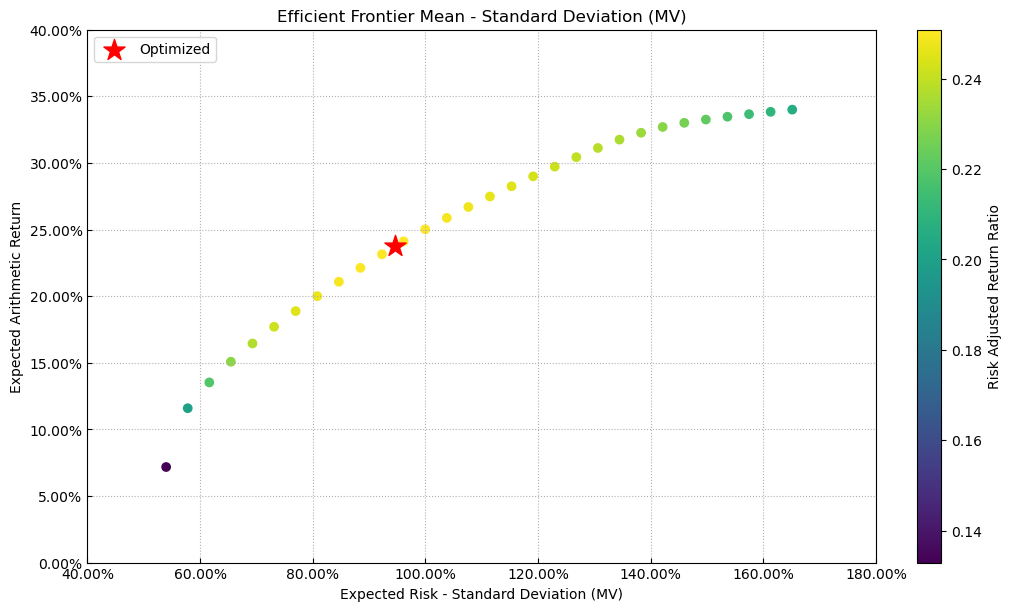

In [51]:
# Visualize the efficient frontier 
factor_model.plot_frontier()

---

### Concluding Remarks

We hope this notebook has provided a useful introduction to portfolio construction using **RiskModels data**. By integrating high-quality return and risk data from Blue Water Macro with flexible optimization tools, you can explore a range of investment strategies — from traditional mean-variance optimization to more sophisticated factor-aware approaches.

The example workflows shown here are just the beginning. The [PortfolioOptimizer](https://github.com/drewtilley/portfolio-optimizer-notebooks) framework is designed to be modular and extensible, and the dataset is intended to make advanced risk models more accessible to analysts, researchers, and asset managers.

This repository is public and intended as a living demo — contributions, suggestions, and questions are welcome. If you have feedback or ideas for additional functionality, factor models, or optimization objectives, please [open an issue](https://github.com/drewtilley/portfolio-optimizer-notebooks/issues) or contact us directly.

> 📬 For questions about using RiskModels data in your own workflows — including access to full datasets — feel free to reach out to [support@riskmodels.net](mailto:support@riskmodels.net).

Thanks for exploring with us!
